# Measuring the Welfare Cost of Inflation

*Author: Mohammed Aït Lahcen, University of Basel*

In this notebook I present several methods and results related to measuring the cost of inflation in terms of aggregate social welfare. This topic is an old and enduring one in the monetary economics literature.

In particular, I replicate some of the results presented in Lucas (2000), Lagos and Wright (2005) and Craig and Rocheteau (2006).

## Fitting money demand data

First, we do some imports as usual...

In [25]:
# Computations imports
import numpy as np
from scipy.integrate import quad as integrate
import scipy.optimize as opt
from scipy.optimize import curve_fit

# Data imports
import pandas as pd
from lmfit import  Model

# Graphics imports
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)  # Sets the size of the figures in the notebook
import matplotlib.pyplot as plt
import seaborn as sns  # Better quality figures
from cycler import cycler
import matplotlib.style
matplotlib.style.use('ggplot')

... and then have a look at the money demand data used by Lucas (2000).

<IPython.core.display.Javascript object>


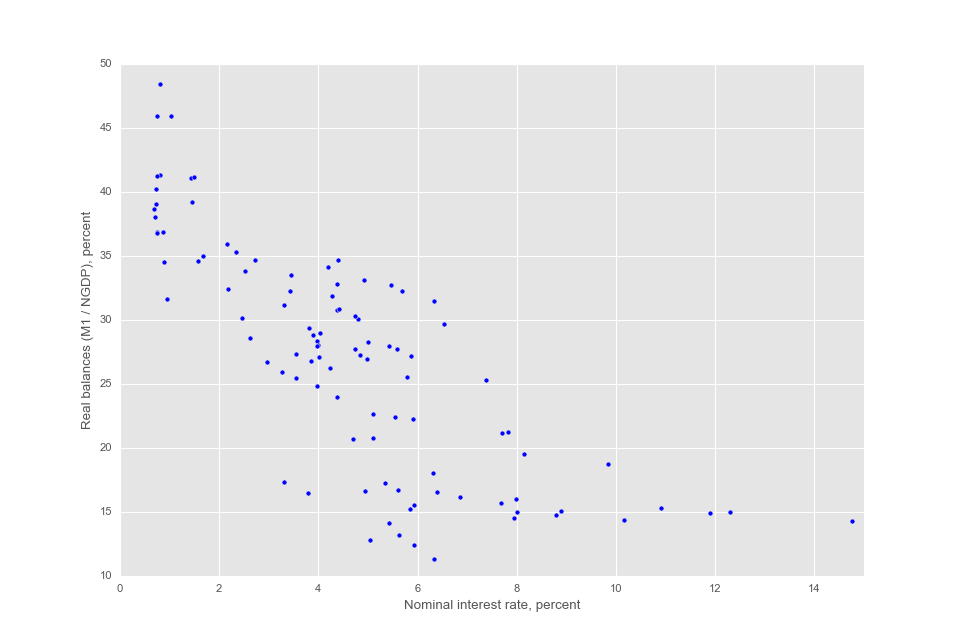

In [30]:
data = pd.read_table('lucasdata.txt', names = ['Nominal interest rates','Real balances'] ,header = None)

plt.figure()
plt.scatter(data['Nominal interest rates']*100,data['Real balances']*100)
plt.xlim(0,15)
plt.ylim(10,50)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Real balances (M1 / NGDP), percent')
plt.show()

Following Lucas (2000), I fit the money demand data with a log-log specification: $m(r) = A r^{-\eta}$ and a semi-log specification: $m(r) = A e^{-\eta r}$. To do this, I use `curve_fit`, a non-linear least squares curve fitting function available in `scipy`. Another option would be to use the lmfit package.

In [3]:
def log_md(r,A,eta):
    """
    Log-log specification for the Money Demand function:
    m(r) = A r^{-\eta}
    
    """
    return A * r ** (-eta)

def slog_md(r,A,eta):
    """
    Semi-log specification for the Money Demand function:
    m(r) = A e^{-\eta r}
    
    """
    return A * np.exp(-eta*r)

log_est = curve_fit(log_md, data['Nominal interest rates'], data['Real balances'])[0]
slog_est = curve_fit(slog_md, data['Nominal interest rates'], data['Real balances'])[0]
print('Estimated parameters for the log-log specification: A =', log_est[0],' eta =',log_est[1])
print('Estimated parameters for the semi-log specification: A =', slog_est[0],' eta =',slog_est[1])

Estimated parameters for the log-log specification: A = 0.0978394998068  eta = 0.299522607081
Estimated parameters for the semi-log specification: A = 0.430582904172  eta = 11.0278018694


Next, we plot the two fitted curves along with the data. This is easily done by passing the estimated parameters to the two specifications which I then evaluate over the grid of the nominal interest rate.

<IPython.core.display.Javascript object>


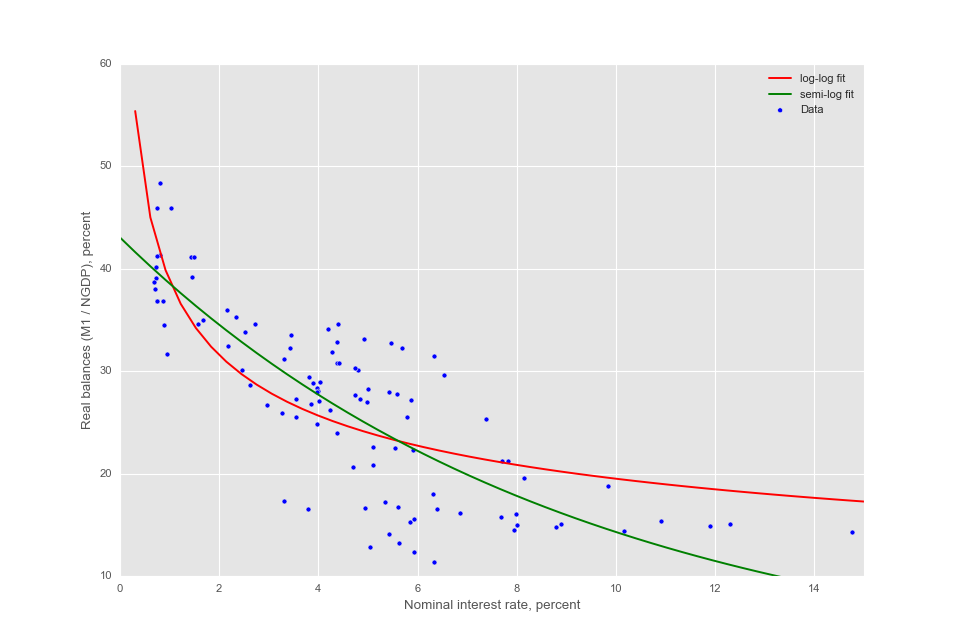

In [29]:
plt.figure()
plt.scatter(data['Nominal interest rates']*100,data['Real balances']*100, label = 'Data')
r = np.linspace(0,0.15)
plt.plot(r*100, log_md(r, *log_est)*100, 'r-', label='log-log fit')
plt.plot(r*100, slog_md(r, *slog_est)*100, 'g-', label='semi-log fit')
plt.xlim(0,15)
plt.ylim(10,60)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Real balances (M1 / NGDP), percent')
plt.legend(loc='best')
plt.show()

## A reduced-form measure of the welfare cost of inflation

In order to measure the cost of inflation, we consider the welfare cost of increasing the nominal interest rate starting from $r_0 = 3\%$ assumed to correspond to an inflation rate of 0. Following Lucas (2000), this is done by measuring the area under the fitted money demand curve for the log-log and semi-log specifications.

Define the function measuring the welfare cost of an increase in interest rates from r0 to r1 in terms of the decrease in real balances from m0 to m1. Since we first approximate the money demand and we need to measure the cost using instead the inverse money demand a little geometric manipulation is needed.

In [26]:
# Welfare cost using the log-log specification
def log_wc(r1,r0,*p):  
    integral, err = integrate(lambda r: log_md(r, *p),r0,r1)
    return integral - (r1 - r0) * log_md(r1,*p) + (log_md(r0,*p) - log_md(r1,*p)) * r0

# Welfare cost using the semi-log specification
def slog_wc(r1,r0,*p):
    integral, err = integrate(lambda r: slog_md(r, *p),r0,r1)
    return integral - (r1 - r0) * slog_md(r1,*p) + (slog_md(r0,*p) - slog_md(r1,*p)) * r0

<IPython.core.display.Javascript object>


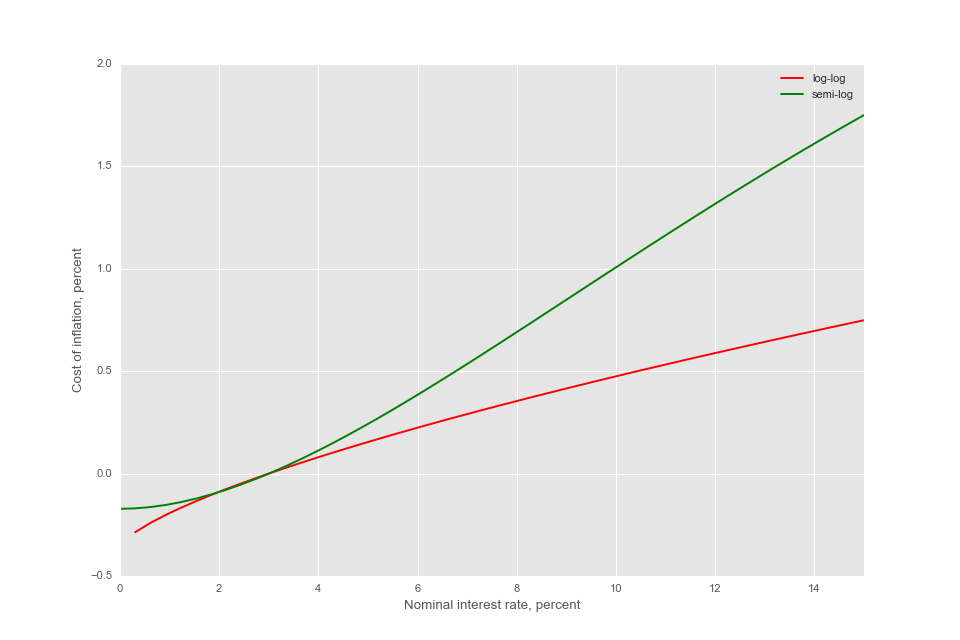

In [28]:
r0 = 0.03
r1 = np.linspace(0,0.15)
plt.plot(r1*100, [log_wc(x,r0,*log_est)*100 for x in r1], 'r-', label='log-log')
plt.plot(r1*100, [slog_wc(x,r0,*slog_est)*100 for x in r1], 'g-', label='semi-log')
plt.xlim(0,15)
#plt.ylim(-0.5,2)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Cost of inflation, percent')
plt.legend(loc='best')
plt.show()

## A model-based measure of the welfare cost of inflation

Another way of measuring is to use a model where the use money as a means of exchange can be welfare improving. One example, is the money search model proposed by Lagos and Wright (2005). 

The LW model can be reduced to two equations. The first equation specifies the quantity traded in the decentralized market (DM) where money is essential given the frictions present in the economy:
$$ q = \arg \max{\lbrace -rv(q) + \sigma[u(q) - v(q)] \rbrace} $$

The second equation specifies the pricing mechanism $v(q)$ mapping the quantity acquired $q$ to the price paid in terms of real balances $z = v(q)$. The pair $(q,z)$ are typically called the terms of trade. Several pricing mechanisms are possible: bargaining (e.g. Nash, Kalai), competitive pricing, markup pricing, price posting, price sampling à la Burdett-Judd, etc.

The first order condition resulting from the Lagos-Wright model is:
$$\frac{u'(q)}{v'(q)} = \frac{r}{\sigma} + 1$$
where $q$ depends on the pricing mechanism $v(q)$, the cost of money $r$ and the probability of trading $\sigma$. In particular, this optimality condition links the utility of consumping $q$ to the opportunity cost of carrying money $r$.

The aggregate money demand is defined as: $ L = \dfrac{M}{\sigma M + p A}$ where $A$ is the real output in the centralized market (CM), and $p$ is the price of the general good in the CM. Assuming a measure 1 of agents and replacing $M/p$ by the model-based money demand $z = v(q)$ I get:
$$L = \dfrac{z}{\sigma z + A}$$ where $z$ is determined through the first order condition above.

In what follows we will explore the welfare cost of inflation based on the Lagos-Wright model using different pricing mechanisms:
* Proportional solution
* Nash bargaining
* Constant mark-up

In order to calibrate the model, we adopt the following functional forms:

$$ 
\begin{align}
u(q) =& \frac{q^{1-\eta}}{1-\eta} \quad \text{where} \quad \eta \geq 0
\\
c(q) =& q 
\end{align}
$$
The matching probability is set to $\sigma = 1/2$.

* **Proportional bargaining**

In the proportional bargaining solution (Kalai, 1977), the buyer's surplus is a constant fraction $\theta$ of the match surplus:
$$u(q) - v(q) = \theta \left[ u(q) - c(q) \right]$$

This implies the following pricing function:
$$v(q) = (1 - \theta) u(q) + \theta c(q)$$

Replacing $v(q)$ and the specified functional forms in the first order condition above and solving for $q$, we get the optimal quantity $q^*$ as a function of the parameters $\theta$, $\sigma$ and $\eta$ and the nominal interest rate $r$:
$$q^* = \left[ \frac{ \theta(r + \sigma)}{\theta \sigma - (1-\theta)r} \right]^{\frac{-1}{\eta}}$$

Plugging $q^*$ into $v(q)$, one gets:
$$z^* = v(q^*) = \frac{1-\theta}{1-\eta} \left[ \frac{ \theta(r + \sigma)}{\theta \sigma - (1-\theta)r} \right]^{\frac{-(1-\eta)}{\eta}} + \theta \left[ \frac{ \theta(r + \sigma)}{\theta \sigma - (1-\theta)r} \right]^{\frac{-1}{\eta}} $$

Inserting $z^*$ into the aggregate money demand equation $L = \dfrac{z}{\sigma z + A}$, we can estimate the parameters $\eta$ and $A$ for different values of $\theta$ using NLLS.

#### Fitting the data

In [34]:
sigma = 1/2

theta = 1

def q_kalai(r):
    return (theta * (r + sigma) / (theta * sigma - (1 - theta) * r)) ** (-1/eta)

# Aggregate money demand equation

def kalai_md(r,A,eta):
    z_star = ((1 - theta) / (1 - eta)) * ((theta * (r + sigma) / (theta * sigma - (1 - theta) * r)) ** (-(1-eta) / eta)) + theta * ((theta * (r + sigma) / (theta * sigma - (1 - theta) * r)) ** (-1 / eta))
    return (sigma + A / z_star) ** (-1)

# Fitting the aggregate money demand equation for various values of theta
for theta in [1, 0.61, 0.50, 0.33]:
    kalai_est = curve_fit(kalai_md, data['Nominal interest rates'], data['Real balances'],(2,0.11))[0]
    print('For theta =', theta, ': A =', kalai_est[0],' eta =',kalai_est[1])

For theta = 1 : A = 1.82482808098  eta = 0.144223868333
For theta = 0.61 : A = 2.04910736521  eta = 0.223101577165
For theta = 0.5 : A = 2.18738347776  eta = 0.264388598206
For theta = 0.33 : A = 2.64942808907  eta = 0.373275905632


#### Optimal allocation

Now, we determine the allocation $q^*$ for a given interest rate $r$ and bargaining power $\theta$ using the estimated parameters:

In [ ]:
def q_star(r):
    return (theta * (r + sigma) / (theta * sigma - (1 - theta) * r)) ** (-1/eta)

for r in [0.13, 0.03]:
    for theta in [1,0.61, 0.50, 0.33]:
        popt3, pcov3 = curve_fit(func3, data['Nominal interest rates'], data['Real balances'],(2,0.11))
        eta = popt3[1]
        print('For theta =', theta, 'and r = ', r,': q =', q_star(r))

We can clearly see that the higher the bargaining power of the buyer and the lower the cost of money the higher is the quantity bought in the DM.

#### Compensated welfare cost

In order to compute the welfare cost of inflation, we use the compensated welfare method which measures the welfare cost of going from a steady state with interest rate $r_0$ to a steady state with a higher rate $r_1$ by the rate of decrease in consumption $\Delta$ which makes consumers indifferent between the two steady states. This measure is based on the [compensating variation](https://en.wikipedia.org/wiki/Compensating_variation) concept introduced by John Hicks (1939). The welfare cost of inflation is defined by:

$$ \sigma \left[u(q_{r_0}-\Delta q_{r_0}) - c(q_{r_0})\right] + (1 - \Delta) A = \sigma \left[u(q_{r_1}) - c(q_{r_1})\right] + A $$

Using the functional forms assumed above, we get the following expression:
$$
\frac{q_{r_0}^{1-\eta}}{1-\eta} (1-\Delta)^{1-\eta} - q_{r_0} - \frac{A}{\sigma} \Delta = \frac{q_{r_1}^{1-\eta}}{1-\eta} - q_{r_1}
$$

In [ ]:
import scipy.optimize as opt

def wc_proport(r1,r0,*popt):
    A, eta = popt
    wc = opt.fsolve(lambda delta:((q_star(r0) ** (1-eta)) / (1 - eta)) * ((1 - delta) ** (1 - eta)) - A * delta / sigma - ((q_star(r1)) ** (1-eta))/(1-eta) - q_star(r0) + q_star(r1),0.001)
    # I provide delta = 0.001 as an initial guess
    return wc

for theta in [1,0.61, 0.5, 0.33]:
    popt3, pcov3 = curve_fit(func3, data['Nominal interest rates'], data['Real balances'],(2,0.11))
    print('For theta = ',theta,' Delta = ','{:04.2f}'.format(float(wc_proport(0.13,0.03,*popt3)*100)),'%')

Using the results above, we can replicate figure 5 of Craig and Rocheteau (2006):

In [ ]:
# Plotting the results
r0 = 0.03
r1 = np.linspace(0,0.15)
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', ['r', 'g', 'b','y'])) # Cycles through colors for the curve
for theta in [1,0.8, 0.5, 0.3]:
    popt3, pcov3 = curve_fit(func3, data['Nominal interest rates'], data['Real balances'],(2,0.11))
    ax.plot(r1*100, [wc_proport(x,r0,*popt3)*100 for x in r1], label=r'$\theta = %.2f$' % theta)
plt.xlim(0,15)
#plt.ylim(-1.5,7)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Cost of inflation, percent')
plt.legend(loc='best')
plt.show()

As $\theta$ goes from 1 to 0.3, the welfare cost of a 10% increase in inflation goes from slightly below 0.5% of GDP to around 6.5% of GDP.

### 4.2. Nash bargaining

Using the Nash bargaining solution, we have:

$$
v(q) = \frac{\theta u'(q) c(q) + (1-\theta) c'(q) u(q)}{\theta u'(q) + (1- \theta) c'(q)}
$$

and $q^*$ satisfies
$$
\frac{u'(q^*)}{v'(q^*)} = 1 + \frac{r}{\sigma}
$$

Replacing with the functional forms we get:

$$
z(q) = \frac{\theta q^{1-\eta} + (1- \theta) \frac{q^{1-\eta}}{1-\eta}}{\theta q^{-\eta} + 1 - \theta}
$$

and

$$
z'(q) = \frac{(1- \theta)(1-\theta \eta) q^{-\eta} + \theta(1 + (1-\theta) \frac{\eta}{1-\eta})q^{-2\eta}}{(\theta q^{-\eta} + 1 - \theta)^2}
$$

#### Fitting the data

In [ ]:
from scipy.misc import derivative

sigma = 1/2

theta = 1

def z_nash(q,eta):
    return (theta * q ** (1-eta) + (1 - theta) * q ** (1-eta) / (1 - eta)) / (theta * q ** (-eta) + 1 - theta)

def dz_nash(q,eta): # First derivative of z(q)
    return (theta * (1 + (eta / (1 - eta)) * (1 - theta)) * (q ** (-2 * eta)) + (1 - theta) * (1 - theta * eta) * (q ** (-eta))) / ((theta * (q ** (-eta)) + 1 - theta) ** 2)

def q_star_nash(r,eta):
    y, = opt.root(lambda q: (q ** (-eta)) / dz_nash(q,eta) - 1 - (r / sigma),1,method='lm').x
#     y = opt.fsolve(lambda q: (q ** (-eta)) / dz_nash(q,eta) - 1 - (r / sigma),1)
#     y, = opt.root(lambda q: (q ** (-eta)) / derivative(z_nash,q,dx=1e-6,args=(eta,)) - 1 - (r / sigma),1,method='lm').x
    return y

# Aggregate money demand equation

def func4(r,A,eta):
    return (sigma + A / z_nash(q_star_nash(r,eta),eta)) ** -1

# Fitting the aggregate money demand equation
# Loop over different values of theta

# # Using curve_fit
# print('Using curve_fit')
# for theta in [1.0, 0.8, 0.5, 0.3]:
#     popt4, pcov4 = curve_fit(func4, data['Nominal interest rates'], data['Real balances'],(1.8,0.2))
#     print('For theta =', theta, ': A =', popt4[0],' eta =',popt4[1])


# Using lmfit
model4 = Model(func4)
print('Using lmfit')
for theta in [1.0, 0.8, 0.5, 0.3]:
    result4 = model4.fit(data['Real balances'],r=data['Nominal interest rates'], A = 1.8, eta = 0.2,method = 'lbfgsb')
    popt4 = list(result4.best_values.values())
    print('For theta =', theta, ': A =', popt4[1],' eta =',popt4[0])

#### Optimal allocation

Next, we determine the optimal allocation $q^*$ under different interest rates and $\theta$ values in the same way as in the proportional bargaining part.

In [ ]:
# # Using curve_fit
# print('Using curve_fit')
# for r in [0.13, 0.03]:
#     for theta in [1, 0.6, 0.50, 0.34]:
#         popt4, pcov4 = curve_fit(func4, data['Nominal interest rates'], data['Real balances'],(1.2,0.11))
#         eta = popt4[1]
#         print('For theta =', theta, 'and r = ', r,': q =', q_star_nash(r,eta))
        
# Using lmfit
model4 = Model(func4)
print('Using lmfit')
for r in [0.13, 0.03]:
    for theta in [1, 0.6, 0.50, 0.34]:
        result4 = model4.fit(data['Real balances'],r=data['Nominal interest rates'], A = 1.8, eta = 0.2,method = 'lbfgsb')
        eta = list(result4.best_values.values())[0]
        print('For theta =', theta, 'and r = ', r,': q =', q_star_nash(r,eta))

#### Compensated welfare loss

Now, we compute the compensated welfare loss associated with different levels of the bargaining power $\theta$:

In [ ]:
def wc_nash(r1,r0,*popt):
    A, eta = popt
    wc = opt.root(lambda delta:((q_star_nash(r0,eta) ** (1-eta)) / (1 - eta)) * ((1 - delta) ** (1 - eta)) - A * delta / sigma - ((q_star_nash(r1,eta)) ** (1-eta))/(1-eta) - q_star_nash(r0,eta) + q_star_nash(r1,eta),0.01,method='lm')
    return wc.x

for theta in [1,0.6, 0.5, 0.34]:
    popt4, pcov4 = curve_fit(func4, data['Nominal interest rates'], data['Real balances'],(1.2,0.11))
    print('Delta = ','{:04.2f}'.format(float(wc_nash(0.13,0.03,*popt4)*100)),'%')

In [ ]:
# Plotting the results
r0 = 0.03
r1 = np.linspace(0,0.15)
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', ['r', 'g', 'b','y'])) # Cycles through colors for the curve
for theta in [0.99,0.8, 0.5, 0.3]:
    popt4, pcov4 = curve_fit(func4, data['Nominal interest rates'], data['Real balances'],(1.2,0.11))
    ax.plot(r1*100, [wc_nash(x,r0,*popt4)*100 for x in r1], label=theta)
#plt.xlim(0,15)
#plt.ylim(-0.5,2)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Cost of inflation, percent')
plt.legend(loc='best')
plt.show()

### 4.3. Constant markup pricing

Finally, I try to compute the welfare cost of inflation using a constant markup pricing instead of an explicit bargaining solution. In this case, the money transfer from the buyer to the seller corresponds to the cost incurred by the seller augmented by a certain percentage $\mu$ with $\mu \geq 0$ such that:

$$
z(q) = (1+\mu)c(q)
$$

and $q^*$ satisfies the usual first order condition:
$$
\frac{u'(q)}{z'(q)} = 1 + \frac{r}{\sigma}
$$

Replacing with the assumed functional forms:
$$
q^* = \left[(1+\mu) (1 + \frac{r}{\sigma})\right]^{-\frac{1}{\eta}}
$$

$$
z(q^*) = (1+\mu)^{\frac{\eta - 1}{\eta}} (1 + \frac{r}{\sigma})^{-\frac{1}{\eta}}
$$

#### Fitting the data

In [ ]:
sigma = 1/2

theta = 1

mu = 0.33

def z_star_markup(r,eta):
    return ((1 + mu)**((eta-1)/eta))*((1 + r/sigma)**(-1/eta))

# Aggregate money demand equation

def func5(r,A,eta):
    return (sigma + (A / z_star_markup(r,eta))) ** (-1)

# Fitting the aggregate money demand equation
# Loop over different values of theta
for mu in [0, 0.1, 0.2]:
    popt5, pcov5 = curve_fit(func5, data['Nominal interest rates'], data['Real balances'],(2,0.1))
    print('For mu =', mu, ': A =', popt5[0],' eta =',popt5[1])

#### Optimal allocation

Now, we determine the allocation $q^*$ for a given interest rate $r$ and bargaining power $\theta$:

In [ ]:
def q_star_markup(r,eta):
    return ((1 + mu)*(1 + r/sigma))**(-1/eta)

for r in [0.13, 0.03]:
    for mu in [0, 0.1, 0.2]:
        popt5, pcov5 = curve_fit(func5, data['Nominal interest rates'], data['Real balances'],(2,0.11))
        eta = popt5[1]
        print('For mu =', mu, 'and r = ', r,': q =', q_star_markup(r,eta))

#### Compensated welfare loss

In [ ]:
def wc_markup(r1,r0,*popt):
    # This function solves for delta
    # I provide delta = 0.001 as an initial guess
    A, eta = popt
    wc = opt.fsolve(lambda delta:((q_star_markup(r0,eta) ** (1-eta)) / (1 - eta)) * ((1 - delta) ** (1 - eta)) - A * delta / sigma - ((q_star_markup(r1,eta)) ** (1-eta))/(1-eta) - q_star_markup(r0,eta) + q_star_markup(r1,eta),0.001)
    return wc

for mu in [0, 0.1, 0.2]:
    popt5, pcov5 = curve_fit(func5, data['Nominal interest rates'], data['Real balances'],(2,0.11))
    print('Delta = ','{:04.2f}'.format(float(wc_markup(0.13,0.03,*popt5)*100)),'%')

In [ ]:
# Plotting the results
r0 = 0.03
r1 = np.linspace(0,0.15)
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', ['r', 'g', 'b'])) # Cycles through colors for the curve
for mu in [0, 0.1, 0.2]:
    popt5, pcov5 = curve_fit(func5, data['Nominal interest rates'], data['Real balances'],(2,0.11))
    ax.plot(r1*100, [wc_markup(x,r0,*popt5)*100 for x in r1], label=mu)
#plt.xlim(0,15)
#plt.ylim(-0.5,2)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Cost of inflation, percent')
plt.legend(loc='best')
plt.show()